<a href="https://colab.research.google.com/github/dileep9968/pytorch/blob/main/08_Pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Get Setup

In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [2]:
try:
  from torchinfo import summary
  print("torchinfo is already installed")
except:
  print(f"[INFO] couldn't find torchinfo, installing it...")
  !pip install torchinfo
  from torchinfo import summary


try:
  from going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
  print("going_modular is already installed")
except:
  print(f"[INFO] couldn't find going_modular, installing it...")
  !git clone 'https://github.com/mrdbourke/pytorch-deep-learning'
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py .
  !rm -rf pytorch-deep-learning
  print("going_modular is installed")
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
  print("helper_functions is installed")

[INFO] couldn't find torchinfo, installing it...
[INFO] couldn't find going_modular, installing it...
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 4356 (delta 213), reused 254 (delta 178), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 31.48 MiB/s, done.
Resolving deltas: 100% (2585/2585), done.
Updating files: 100% (248/248), done.
going_modular is installed
helper_functions is installed


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Get Data

In [4]:
# Download pizza, stea, sushi images from github
image_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                           destination='pizza_steak_sushi')
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path/'train'
test_dir = image_path/'test'
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create datasets and dataloader

In [6]:
from going_modular.going_modular import data_setup
from torchvision import transforms
# Create image size
IMAGE_SIZE=224

# create transform pipeline
manual_transforms = transforms.Compose([
          transforms.Resize(size=(IMAGE_SIZE,IMAGE_SIZE)),
  	      transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# create a batch size of 32
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single a image

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [9]:
# Get a single image and label from batch
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

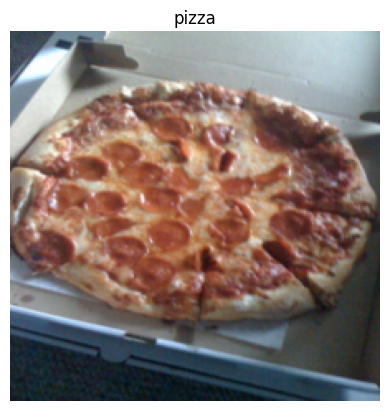

In [10]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating VIT:

## Using a pretrained VIT from `torchvision.models`
**Why use a pretrained model?**
* Sometime data is limited
* Limited training resource
* Get better result

In [6]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [8]:
from going_modular.going_modular import data_setup
from torchvision import transforms

In [9]:
# Get pretrained weights from VIT-base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 83.1MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [10]:
iter(pretrained_vit.parameters())

<generator object Module.parameters at 0x7e6b0eb52f80>

In [11]:
# Freeze the base parameters
for param in pretrained_vit.parameters():
  param.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)
pretrained_vit.heads = torch.nn.Linear(in_features=768, out_features=3).to(device)

In [12]:
from torchinfo import summary

summary(model = pretrained_vit,
        input_size = (1,3,224,224),
        col_names = ['input_size','output_size','num_params','trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### Preaparing data form pretrained model

In [13]:
# Get automtic transform frm pretraine vit weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [14]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

### Train features extractor VIT model

In [15]:
from going_modular.going_modular import engine

# create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# train model

torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit_results = engine.train(model=pretrained_vit,
                                    train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    loss_fn=loss_fn,
                                    epochs = 10,
                                    device = device
                                      )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


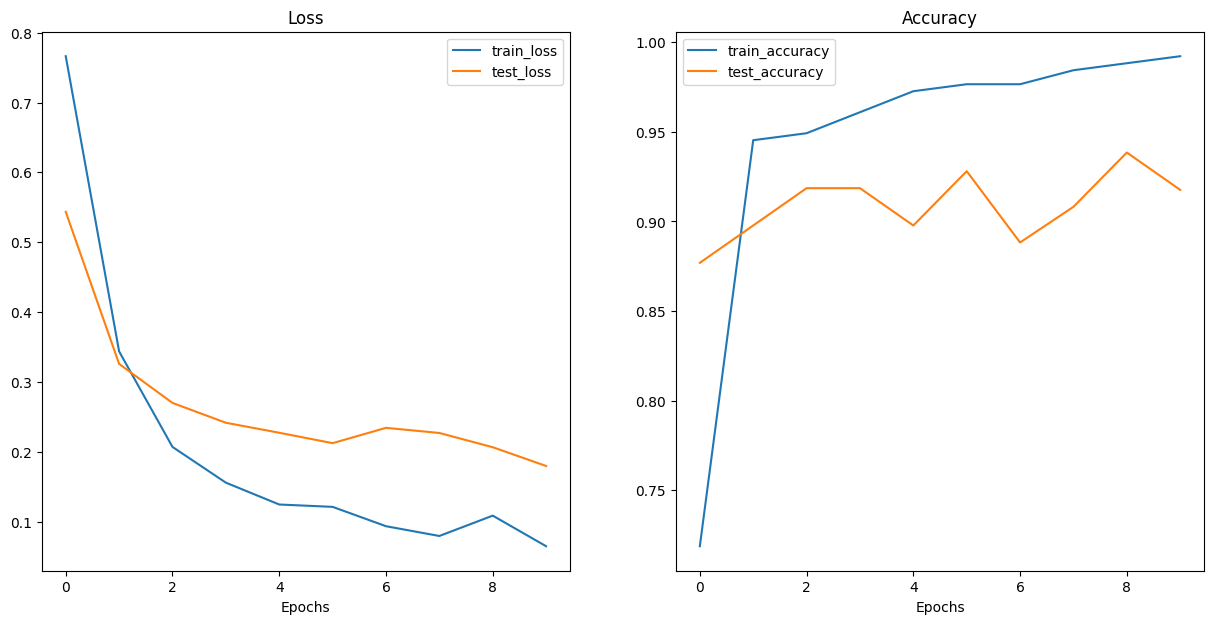

In [16]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### Save out best perfoming VIT model

In [18]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir='models',
                 model_name='pretrained_vit_features_extractor_pizza_steak_sushi.pth')


[INFO] Saving model to: models/pretrained_vit_features_extractor_pizza_steak_sushi.pth


In [22]:
from pathlib import Path

pretrained_vit_path = Path('models/pretrained_vit_features_extractor_pizza_steak_sushi.pth').stat().st_size//(1024*1024)
print(f"pretrained vit feature extractor model size: {pretrained_vit_path} MB")

pretrained vit feature extractor model size: 327 MB


## Predicting on custom image

Downloaded custom image


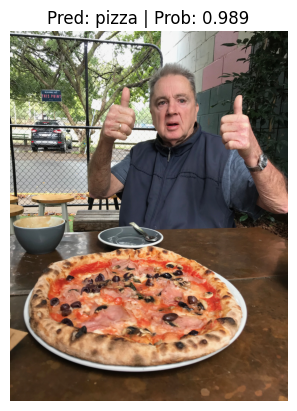

In [26]:
import requests
from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = image_path / '04-pizza-dad.jpeg'

if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    requests = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
    print('Downloading custom image...')
    f.write(requests.content)
    print('Downloaded custom image')

else:
  print(f"Custom image already exists at: {custom_image_path}")

pred_and_plot_image(model=pretrained_vit,
                    image_path = custom_image_path,
                    class_names = class_names)